Import dataset

In [1]:
import numpy as np
import torch
from data.dataset import OneDDatasetLoader, DatasetLoader
from typing import List
from preprocessing.batching import merge_graphs
from torch_geometric.loader import DataLoader

def train_eval_split(dataset : DatasetLoader, train_id : List, eval_id : List):
    # Get batching id
    if dataset._sub_dir == '/batched/':
        batching_id = dataset.batching_id.numpy()
        train_id = list(np.where(np.isin(batching_id, train_id) == True)[0])
        eval_id = list(np.where(np.isin(batching_id, eval_id) == True)[0])
    # Train dataset
    train_dataset = [dataset[i] for i in train_id]
    # Test dataset
    eval_dataset = [dataset[i] for i in eval_id]
    return train_dataset, eval_dataset

In [2]:
dataset = OneDDatasetLoader(
    root_dir='/data1/tam/downloaded_datasets_nodeattr_v3',
    sub_dir='/batched/'
)
print('Dataset loaded.')

train_dataset, test_dataset = train_eval_split(dataset,
    train_id=list(range(0,15)), eval_id=list(range(15,30)))

Dataset loaded.


In [3]:
train_loader = DataLoader(train_dataset, batch_size=5)
test_loader = DataLoader(test_dataset, batch_size=5)

Train

In [4]:
import os
import torch
from networks.network_parc_v2 import MeshGraphNet, PARC_reduced
# from networks.network_parc import PARC_reduced
os.environ["CUDA_VISIBLE_DEVICES"]="2"
from networks.network_recurrent import objectview
from networks.loss import WeightedMSELoss
CUDA_LAUNCH_BLOCKING=1
torch.cuda.empty_cache()

# Model params
args = objectview({
    'n_fields' : 2,
    'n_timesteps' : 1,
    'n_hiddenfields' : 128,
    'n_meshfields' : 10, # dataset[0].node_attr.size(1),
    'n_bcfields' : 1,
    'time' : 4.0,
    'device' : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'lr' : 2e-7,
    'weight_decay' : 5e-4,
    'epoch' : 100,
    'train_lambda' : 0.5
})

# # Model initializing
# model1 = MeshGraphNet(
#     node_in_channels=args.n_fields + args.n_hiddenfields + args.n_bcfields,
#     node_out_channels=args.n_fields,
#     hidden_channels=args.n_hiddenfields,
#     n_layers=10
# )

# model2 = MeshGraphNet(
#     node_in_channels=args.n_fields,
#     node_out_channels=args.n_fields,
#     hidden_channels=args.n_hiddenfields,
#     n_layers=10
# )

# model0 = MeshGraphNet(
#     node_in_channels=args.n_meshfields,
#     node_out_channels=args.n_hiddenfields,
#     hidden_channels=args.n_hiddenfields,
#     n_layers=10
# )

# model = objectview({
#     'derivative_solver' : model1.to(args.device),
#     'integral_solver' : model2.to(args.device),
#     'shape_descriptor' : model0.to(args.device)
# })

# optimizer1 = torch.optim.Adam(model.derivative_solver.parameters(), lr=args.lr, weight_decay=args.weight_decay)
# optimizer2 = torch.optim.Adam(model.integral_solver.parameters(), lr=args.lr, weight_decay=args.weight_decay)
# optimizer0 = torch.optim.Adam(model.shape_descriptor.parameters(), lr=args.lr, weight_decay=args.weight_decay)

model = PARC_reduced(
    n_fields=args.n_fields,
    n_timesteps=args.n_timesteps,
    n_hiddenfields=args.n_hiddenfields,
    n_meshfields=args.n_meshfields,
    n_bcfields=args.n_bcfields
).to(args.device)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

criterion = torch.nn.MSELoss()
# criterion = WeightedMSELoss()

In [5]:
# Train function v2
def train(model, data, args):
    n_time = data.pressure.size(1)
    timesteps = args.time / n_time
    # edge_index = data.edge_index.to(args.device)
    edge_index = torch.cat([
        data.edge_index, torch.flip(data.edge_index, dims=[0]
        )], dim=1).to(args.device)
    mesh_features = data.node_attr.to(args.device)
    F_bc = data.flowrate_bc.to(args.device)
    # weight = data.node_weight.to(args.device)

    F_initial = torch.cat([
        data.pressure[:,0].unsqueeze(1), 
        data.flowrate[:,0].unsqueeze(1)
    ], dim=-1).to(args.device) # concat pressure and flowrate

    model.n_timesteps = n_time - 1

    Fs, F_dots = model(F_initial, mesh_features, edge_index, F_bc, timesteps)

    Fs_hat = torch.cat([
        data.pressure.unsqueeze(-1), 
        data.flowrate.unsqueeze(-1)
    ], dim=-1).to(args.device) # concat pressure and flowrate
    
    # F_dots_hat = torch.cat([
    #     data.pressure_dot.unsqueeze(-1), 
    #     data.flowrate_dot.unsqueeze(-1)
    # ], dim=-1).to(args.device) # concat pressure and flowrate

    Fs_hat = Fs_hat[:,1:,:]
    # F_dots_hat = F_dots_hat[:,1:,:]
    
    # loss = (1.-args.train_lambda)*criterion(Fs_hat, Fs) + \
    #         args.train_lambda*criterion(F_dots_hat, F_dots)
    loss = criterion(Fs_hat, Fs)

    loss.backward()
    optimizer.step()
    return loss.item()

# Eval function
def eval(model, data, args):
    n_time = data.pressure.size(1)
    timesteps = args.time / n_time
    # edge_index = data.edge_index.to(args.device)
    edge_index = torch.cat([
        data.edge_index, torch.flip(data.edge_index, dims=[0]
        )], dim=1).to(args.device)
    mesh_features = data.node_attr.to(args.device)
    F_bc = data.flowrate_bc.to(args.device)
    # weight = data.node_weight.to(args.device)
    F_initial = torch.cat([
        data.pressure[:,0].unsqueeze(1), 
        data.flowrate[:,0].unsqueeze(1)
    ], dim=-1).to(args.device) # concat pressure and flowrate
    model.n_timesteps = n_time - 1

    with torch.no_grad():
        Fs, F_dots = model(F_initial, mesh_features, edge_index, F_bc, timesteps)

        Fs_hat = torch.cat([
            data.pressure.unsqueeze(-1), 
            data.flowrate.unsqueeze(-1)
        ], dim=-1).to(args.device) # concat pressure and flowrate
        
        # F_dots_hat = torch.cat([
        #     data.pressure_dot.unsqueeze(-1), 
        #     data.flowrate_dot.unsqueeze(-1)
        # ], dim=-1).to(args.device)

        Fs_hat = Fs_hat[:,1:,:]
        # F_dots_hat = F_dots_hat[:,1:,:]

        # loss = (1.-args.train_lambda)*criterion(Fs_hat, Fs) + \
        #     args.train_lambda*criterion(F_dots_hat, F_dots)
        loss = criterion(Fs_hat, Fs)

    # return loss
    return loss.item()

# Training
total_train_loss = []
total_eval_loss = []
# batch = enumerate(list(range(0,10)))
for epoch in range(args.epoch):
    torch.cuda.empty_cache()
    train_loss = 0
    # for data in train_dataset:
    for i in range(train_loader.__len__()):
        data = next(iter(train_loader))
        train_loss += train(model=model, data=data, args=args)

    train_loss /= train_loader.__len__() # len(train_dataset)
    total_train_loss.append(train_loss)

    eval_loss = 0
    # for data in eval_dataset:
    for i in range(test_loader.__len__()):
        data = next(iter(test_loader))
        eval_loss += eval(model=model, data=data, args=args)
    eval_loss /= test_loader.__len__() #len(eval_dataset)
    total_eval_loss.append(eval_loss)
    
    # if (epoch > 25):
    #     args.train_lambda = 0.5
    print(f'Epoch {epoch}: train loss = {train_loss}; eval loss = {eval_loss}')
    if (epoch+1) % 25 == 0:
        torch.save(model.state_dict(), f'models/parc_v4-3_epoch{epoch+1}.pth')

Epoch 0: train loss = 0.07378199004939853; eval loss = 0.06331920404644574
Epoch 1: train loss = 0.06515120845204511; eval loss = 0.07909141814681739
Epoch 2: train loss = 0.06511907839120236; eval loss = 0.06539266010350232
Epoch 3: train loss = 0.054201244856878245; eval loss = 0.06033881345755374
Epoch 4: train loss = 0.05717860237432168; eval loss = 0.06529090287189139
Epoch 5: train loss = 0.057777924671969606; eval loss = 0.059029990461617034
Epoch 6: train loss = 0.05352884779930649; eval loss = 0.05565003555150053
Epoch 7: train loss = 0.05494130359369543; eval loss = 0.058486472798418676
Epoch 8: train loss = 0.058516163211900556; eval loss = 0.06005327383317559
Epoch 9: train loss = 0.05930845280733344; eval loss = 0.05888108253411578
Epoch 10: train loss = 0.058981560153945144; eval loss = 0.057845105598280336
Epoch 11: train loss = 0.05788197358360205; eval loss = 0.05474646141693603
Epoch 12: train loss = 0.05407516591484771; eval loss = 0.04877364699522295
Epoch 13: train

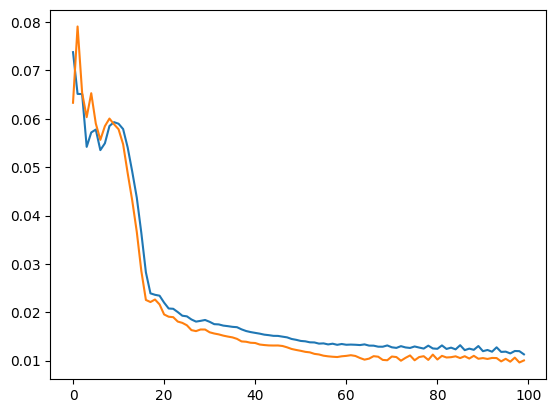

In [6]:
import matplotlib.pyplot as plt
plt.plot(total_train_loss)
plt.plot(total_eval_loss)
# plt.ylim(0,0.1)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(total_train_loss)
plt.plot(total_eval_loss)
# plt.ylim(0,0.1)
plt.show()

Reconstruct CFD output

In [13]:
# Model initializing
model = PARC_reduced(
    n_fields=args.n_fields,
    n_timesteps=args.n_timesteps,
    n_hiddenfields=args.n_hiddenfields,
    n_meshfields=args.n_meshfields,
    n_bcfields=args.n_bcfields
)
model = model.to(args.device)
model.load_state_dict(torch.load('models/parc_v4-3_epoch100.pth'))

<All keys matched successfully>

Dataset loaded.
-1.0


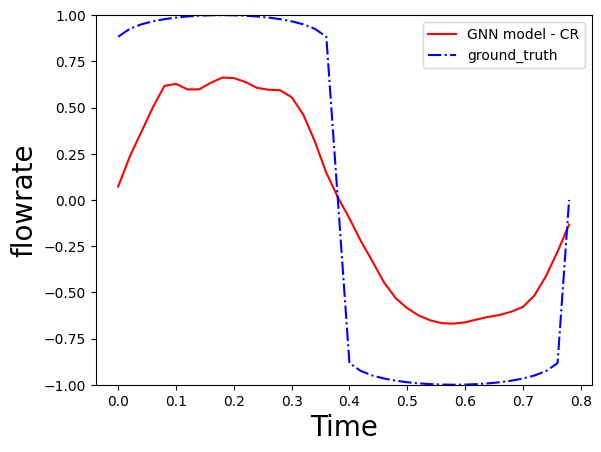

-0.6


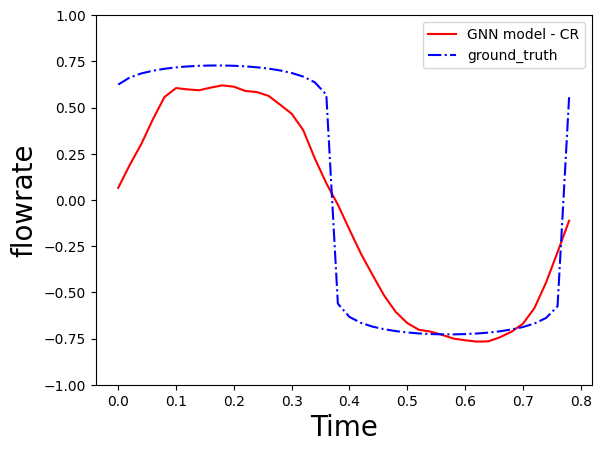

-0.6


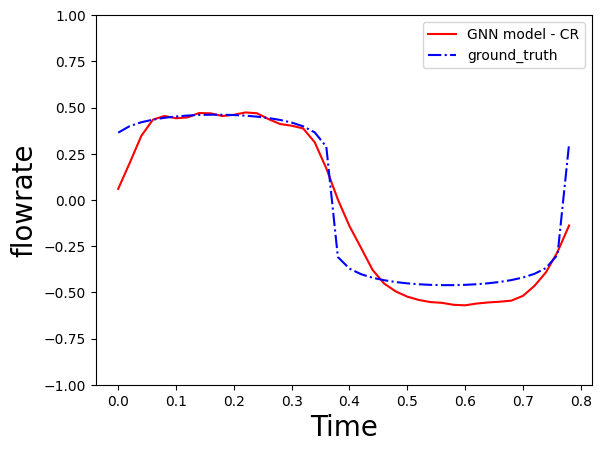

-0.19999999


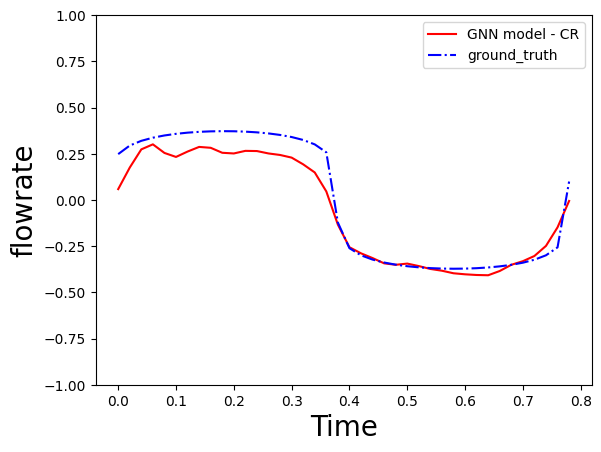

0.20000005


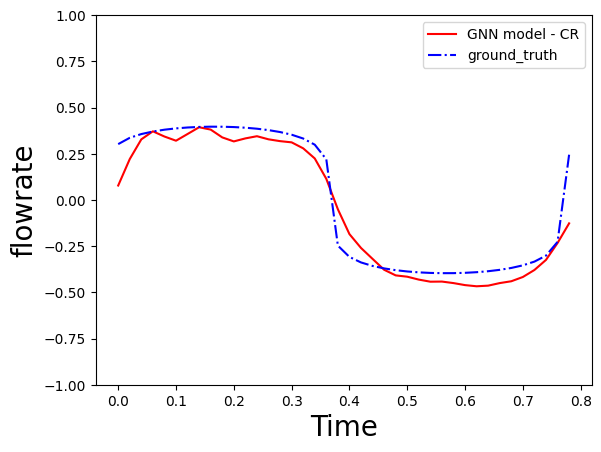

0

In [14]:
# Plot prediction/ground truth
import matplotlib.pyplot as plt

def plot_comparison(model, data):
    # prepare input tensors
    n_time = data.pressure.size(1)
    timesteps = args.time / n_time
    # edge_index = data.edge_index.to(args.device)
    edge_index = torch.cat([
        data.edge_index, torch.flip(data.edge_index, dims=[0]
        )], dim=1).to(args.device)
    mesh_features = data.node_attr.to(args.device)
    F_bc = data.flowrate_bc.to(args.device)
    weight = data.node_weight.to(args.device)
    F_initial = torch.cat([
        data.pressure[:,0].unsqueeze(1), 
        data.flowrate[:,0].unsqueeze(1)
    ], dim=-1).to(args.device) # concat pressure and flowrate
    model.n_timesteps = n_time - 1

    with torch.no_grad():
        Fs, F_dots = model(F_initial, mesh_features, edge_index, F_bc, timesteps)

        Fs_hat = torch.cat([
            data.pressure.unsqueeze(-1), 
            data.flowrate.unsqueeze(-1)
        ], dim=-1).to(args.device) # concat pressure and flowrate
        
        # F_dots_hat = torch.cat([
        #     data.pressure_dot.unsqueeze(-1), 
        #     data.flowrate_dot.unsqueeze(-1)
        # ], dim=-1).to(args.device)

        Fs_hat = Fs_hat[:,1:,:]
        # F_dots_hat = F_dots_hat[:,1:,:]

        # loss = (1.-args.train_lambda)*criterion(Fs_hat, Fs) + \
        #     args.train_lambda*criterion(F_dots_hat, F_dots)

    

    
    # plot
    for i_node in [1, 100, 1000, 20000, 30000]:

        i_field = 1
        y_pred = Fs.cpu().numpy()[i_node,:,i_field]
        y_true = Fs_hat.cpu().numpy()[i_node,:,i_field]
        x = [i * 4.0 /200 for i in range(y_pred.shape[0])]
        print(data.node_attr.numpy()[i_node, 6])
        plt.ylim(-1,1)
        plt.plot(x, y_pred, c='red', label='GNN model - CR')
        plt.plot(x, y_true, c='blue', linestyle='dashdot', label='ground_truth')
        # plt.ylim([-1,1])
        plt.legend(loc='upper right')
        plt.ylabel('flowrate', fontsize=20)
        plt.xlabel('Time', fontsize=20)
        plt.show()
    
    return 0

dataset = OneDDatasetLoader(
    root_dir='/data1/tam/downloaded_datasets_nodeattr_v3',
    sub_dir='/validation/'
)
print('Dataset loaded.')

plot_comparison(model, dataset[37])

In [ ]:
# Plot prediction/ground truth
import matplotlib.pyplot as plt

def plot_comparison(model, data):
    # prepare input tensors
    n_time = data.pressure.size(1)
    timesteps = args.time / n_time
    # edge_index = data.edge_index.to(args.device)
    edge_index = torch.cat([
        data.edge_index, torch.flip(data.edge_index, dims=[0]
        )], dim=1).to(args.device)
    mesh_features = data.node_attr.to(args.device)
    F_bc = data.flowrate_bc.to(args.device)
    weight = data.node_weight.to(args.device)
    F_initial = torch.cat([
        data.pressure[:,0].unsqueeze(1), 
        data.flowrate[:,0].unsqueeze(1)
    ], dim=-1).to(args.device) # concat pressure and flowrate
    model.n_timesteps = n_time - 1

    with torch.no_grad():
        Fs, F_dots = model(F_initial, mesh_features, edge_index, F_bc, timesteps)

        Fs_hat = torch.cat([
            data.pressure.unsqueeze(-1), 
            data.flowrate.unsqueeze(-1)
        ], dim=-1).to(args.device) # concat pressure and flowrate
        
        F_dots_hat = torch.cat([
            data.pressure_dot.unsqueeze(-1), 
            data.flowrate_dot.unsqueeze(-1)
        ], dim=-1).to(args.device)

        Fs_hat = Fs_hat[:,1:,:]
        F_dots_hat = F_dots_hat[:,1:,:]

        # loss = (1.-args.train_lambda)*criterion(Fs_hat, Fs) + \
        #     args.train_lambda*criterion(F_dots_hat, F_dots)

    

    
    # plot
    for i_node in [1, 100, 1000, 10000, 50000]:

        i_field = 1
        y_pred = Fs.cpu().numpy()[i_node,:,i_field]
        y_true = Fs_hat.cpu().numpy()[i_node,:,i_field]
        x = [i * 4.0 /200 for i in range(y_pred.shape[0])]
        print(data.node_attr.numpy()[i_node, 6])
        plt.ylim(-1,1)
        plt.plot(x, y_pred, c='red', label='PIGNN')
        plt.plot(x, y_true, c='blue', linestyle='dashdot', label='ground_truth')
        # plt.ylim([-1,1])
        plt.legend(loc='upper right')
        plt.ylabel('flowrate', fontsize=20)
        plt.xlabel('Time', fontsize=20)
        plt.show()
    
    return 0

dataset = OneDDatasetLoader(
    root_dir='/data1/tam/downloaded_datasets_nodeattr_v2',
    sub_dir='/validation/'
)
print('Dataset loaded.')

plot_comparison(model, dataset[40])